In [1]:
import litebird_sim as lbs
import numpy as np
from swipe_modules import scanning_strategy
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
imo = lbs.Imo()
sim = lbs.Simulation(
    start_time=0,
    duration_s=24*3600,
    description="SWIPE simulation",
)
nside = 256

In [3]:
sim.generate_spin2ecl_quaternions(scanning_strategy.SwipeScanningStrategy(),delta_time_s=1)
instrument_info = lbs.InstrumentInfo.from_imo(url="/releases/v0.0/balloon/SWIPE/instrument_info",imo=imo,)
ch="145"
hwp_radpsec = instrument_info.hwp_rpm*2*np.pi/60.0
channel_info = lbs.FreqChannelInfo.from_imo(url="/releases/v0.0/balloon/SWIPE/"+ch+"/channel_info",imo=imo,)

site_latitude_deg, site_longitude_deg and longitude_speed_deg_per_sec used


In [4]:
dets=[]
detquats=[]
#for detname in channelinfo.detector_names[0:20]:
for detname in channel_info.detector_names[0:10]:
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v0.0/balloon/SWIPE/"+ch+"/"+detname+"/detector_info",
        imo=imo,
    )
    dets.append(det)
    detquats.append(det.quat)

In [5]:
obs, = sim.create_observations(detectors=dets)
pointings = lbs.get_pointings(
    obs,
    sim.spin2ecliptic_quats,
    detector_quats=detquats,
    bore2spin_quat=instrument_info.bore2spin_quat,
)

In [6]:
Mbsparams = lbs.MbsParameters(make_cmb =True,
                              make_fg = True,
                              fg_models=["pysm_synch_0","pysm_dust_0"],
                              gaussian_smooth = False,
                              bandpass_int = False,
                              nside = nside,
                             )

In [7]:
mbs = lbs.Mbs(simulation=sim,
              parameters=Mbsparams,
              channel_list=channel_info,
             )

In [8]:
in_map = mbs.run_all()[0]

[2021-12-31 12:15:15,225 INFO MPI#0000] generating and saving cmb simulations
[2021-12-31 12:15:15,326 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-31 12:15:15,408 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-31 12:15:15,409 INFO MPI#0000] -> fwhm is 0.000000 arcmin


***************** D
***************** D
***************** D


[2021-12-31 12:15:23,739 INFO MPI#0000] Access data from cmb/0000/cmb_0000_date_211231.fits
[2021-12-31 12:15:23,742 INFO MPI#0000] NSIDE = 256
[2021-12-31 12:15:23,743 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-31 12:15:23,744 INFO MPI#0000] INDXSCHM = IMPLICIT
[2021-12-31 12:15:24,009 INFO MPI#0000] generating and saving fg simulations
[2021-12-31 12:15:24,013 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2021-12-31 12:15:24,096 INFO MPI#0000] NSIDE = 512
[2021-12-31 12:15:24,097 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-31 12:15:24,097 INFO MPI#0000] INDXSCHM = IMPLICIT
[2021-12-31 12:15:24,321 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2021-12-31 12:15:24,339 INFO MPI#0000] NSIDE = 512
[2021-12-31 12:15:24,340 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-31 12:15:24,340 INFO MPI#0000] INDXSCHM = IMPLICIT
[2021-12-31 12:15:24,539 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new

In [9]:
lbs.scan_map_in_observations(
    obs, pointings, hwp_radpsec, in_map, fill_psi_and_pixind_in_obs=True
)

In [10]:
lbs.add_noise([obs],'white')

In [11]:
out_map = lbs.make_bin_map([obs],nside).T

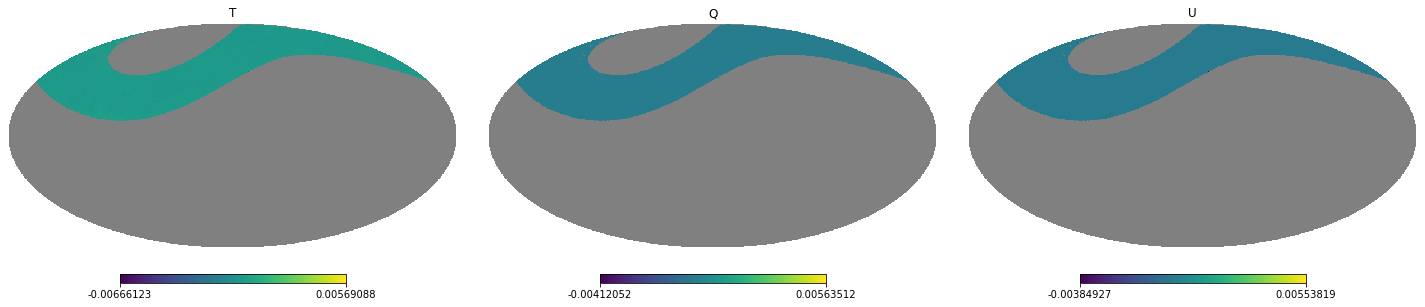

In [12]:
plt.figure(figsize=(20,7))
hp.mollview(out_map[0],sub=131,title='T')
hp.mollview(out_map[1],sub=132,title='Q')
hp.mollview(out_map[2],sub=133,title='U')

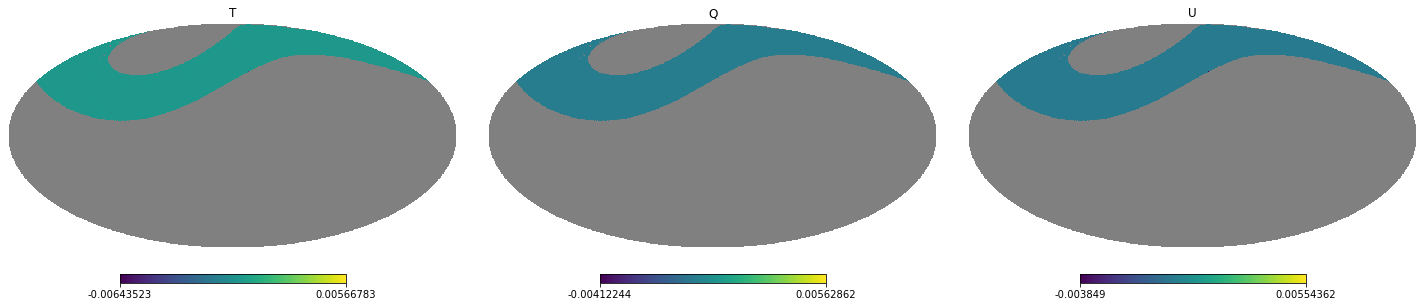

In [13]:
plt.figure(figsize=(20,7))
hp.mollview(out_map[0]-in_map[ch][0],sub=131,title='T')
hp.mollview(out_map[1]-in_map[ch][1],sub=132,title='Q')
hp.mollview(out_map[2]-in_map[ch][2],sub=133,title='U')